In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig, get_peft_model

2024-12-09 09:38:36.511716: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 09:38:37.317420: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 09:38:37.886998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 09:38:38.478082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 09:38:38.483439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting t

In [4]:
import esm

In [5]:
class ESM2Regression(nn.Module):
    def __init__(self, model_path) -> None:
        super().__init__()
        self.esm2, self.alphabet = esm.pretrained.load_model_and_alphabet(model_path)
        self.batch_converter = self.alphabet.get_batch_converter()

        self.mlp = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        self.tok_to_idx = self.alphabet.tok_to_idx
        self.idx_to_tok = {v:k for k,v in self.tok_to_idx.items()}

    def forward(self, batch_tokens):
        rep = self.esm2(batch_tokens, repr_layers=[33], return_contacts=True)
        embedding = rep['representations'][33].mean(1)

        pred = self.mlp(embedding)

        return pred

    # def get_res_batch(self, sequences):
    #     data = [
    #         (f"P{i+1}", seq) for i, seq in enumerate(sequences)
    #     ]
    #     batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
    #     batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

    #     if self.device == 'gpu':
    #         batch_tokens = batch_tokens.cuda()

    #     with torch.no_grad():
    #         results = self.model(batch_tokens, repr_layers=[33], return_contacts=True)

    #     return results, batch_lens

In [6]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [7]:
root = '../..'
data_path = os.path.join(root, 'Data/al_test_experiments/Evolvepro')

In [8]:
file_name = os.path.join(data_path, 'brenan.csv')
df = pd.read_csv(file_name)

In [9]:
df.head()

,seq,function
0,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.265834
1,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.397712
2,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.324874
3,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.151913
4,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,0.261203


In [10]:
model = ESM2Regression(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt')

In [11]:
for name, param in model.named_parameters():
    print(name, param.numel(), param.size(), param.requires_grad)

esm2.embed_tokens.weight 42240 torch.Size([33, 1280]) True
esm2.layers.0.self_attn.k_proj.weight 1638400 torch.Size([1280, 1280]) True
esm2.layers.0.self_attn.k_proj.bias 1280 torch.Size([1280]) True
esm2.layers.0.self_attn.v_proj.weight 1638400 torch.Size([1280, 1280]) True
esm2.layers.0.self_attn.v_proj.bias 1280 torch.Size([1280]) True
esm2.layers.0.self_attn.q_proj.weight 1638400 torch.Size([1280, 1280]) True
esm2.layers.0.self_attn.q_proj.bias 1280 torch.Size([1280]) True
esm2.layers.0.self_attn.out_proj.weight 1638400 torch.Size([1280, 1280]) True
esm2.layers.0.self_attn.out_proj.bias 1280 torch.Size([1280]) True
esm2.layers.0.self_attn_layer_norm.weight 1280 torch.Size([1280]) True
esm2.layers.0.self_attn_layer_norm.bias 1280 torch.Size([1280]) True
esm2.layers.0.fc1.weight 6553600 torch.Size([5120, 1280]) True
esm2.layers.0.fc1.bias 5120 torch.Size([5120]) True
esm2.layers.0.fc2.weight 6553600 torch.Size([1280, 5120]) True
esm2.layers.0.fc2.bias 1280 torch.Size([1280]) True
esm

In [12]:
data = [
            (fun, seq) for i, (seq, fun) in enumerate(zip(df['seq'][:3], df['function'][:3]))
        ]
batch_labels, batch_strs, batch_tokens = model.batch_converter(data)
batch_lens = (batch_tokens != model.alphabet.padding_idx).sum(1)

In [13]:
model(batch_tokens).shape

torch.Size([3, 1])

In [14]:
config = LoraConfig(
    r=4, 
    lora_alpha=1,
    target_modules=["k_proj", "q_proj", "v_proj", "out_proj", "fc1", "fc2"],
    lora_dropout=0.1,
    bias="all",
)

In [15]:
model = get_peft_model(model, config)

In [16]:
model.print_trainable_parameters()

trainable params: 3,510,307 || all params: 654,740,919 || trainable%: 0.5361


In [17]:
for name, param in model.named_parameters():
    if 'mlp' in name:
        param.requires_grad = True

In [18]:
model.print_trainable_parameters()

trainable params: 4,166,179 || all params: 654,740,919 || trainable%: 0.6363


In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.esm2.layers.0.self_attn.k_proj.base_layer.bias
base_model.model.esm2.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.esm2.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.esm2.layers.0.self_attn.v_proj.base_layer.bias
base_model.model.esm2.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.esm2.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.esm2.layers.0.self_attn.q_proj.base_layer.bias
base_model.model.esm2.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.esm2.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.esm2.layers.0.self_attn.out_proj.base_layer.bias
base_model.model.esm2.layers.0.self_attn.out_proj.lora_A.default.weight
base_model.model.esm2.layers.0.self_attn.out_proj.lora_B.default.weight
base_model.model.esm2.layers.0.self_attn_layer_norm.bias
base_model.model.esm2.layers.0.fc1.base_layer.bias
base_model.model.esm2.layers.0.fc1.lora_A.default.weight
base_model.mo

In [20]:
model(batch_tokens)

tensor([[0.0308],
        [0.0306],
        [0.0314]], grad_fn=<AddmmBackward0>)

In [21]:
torch.tensor(batch_labels)

tensor([0.2658, 0.3977, 0.3249])

In [22]:
from scipy import stats
from sklearn.model_selection import train_test_split

In [23]:
class ProteinFunDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class ESM2LoRALit(pl.LightningModule):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.model.cuda()

    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        data = [
            (fun, seq) for (seq, fun) in zip(x, y)
            ]
        batch_labels, batch_strs, batch_tokens = self.model.batch_converter(data)
        batch_lens = (batch_tokens != self.model.alphabet.padding_idx).sum(1)

        batch_tokens = batch_tokens.cuda()

        y_hat = self.model(batch_tokens)
        loss = nn.functional.mse_loss(y_hat.flatten(), y)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        # self.accumulate_batch_loss_train.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        data = [
            (fun, seq) for (seq, fun) in zip(x, y)
            ]
        batch_labels, batch_strs, batch_tokens = self.model.batch_converter(data)
        batch_lens = (batch_tokens != self.model.alphabet.padding_idx).sum(1)

        batch_tokens = batch_tokens.cuda()

        y_hat = self.model(batch_tokens)
        loss = nn.functional.mse_loss(y_hat.flatten(), y)
        self.log("val/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        # self.accumulate_batch_loss_val.append(loss.item())
    
    @staticmethod
    def trainmodel(model, X, y, val=True, debug=True):
        '''
            X - embeddings from esm2
            X - shape (n, features)
            y - shape (n, )
        '''
        if val:
            batch_size = 1
            idx = np.arange(X.shape[0])
            train_idx, val_idx = train_test_split(idx, test_size=0.2)
            train_dataset = ProteinFunDataset(X[train_idx], y[train_idx])
            val_dataset = ProteinFunDataset(X[val_idx], y[val_idx])
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=5, verbose=False, mode="min")

            trainer = pl.Trainer(max_epochs=5, callbacks=[earlystopping_callback],
                                 accelerator="auto",
                                 enable_progress_bar=True,
                                 enable_model_summary=True,
                                 precision="16-mixed",
                                 accumulate_grad_batches=32
                                 )
            trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

            ## Needs to change - we need to load the least val loss model
            # y_pred = validation_step(X[val_idx])
            # val_mse = mean_squared_error(y_pred, y[val_idx])
            # print(f'Train end val mse: {val_mse}')

        else:
            raise Exception("Needs Fix")

    # def on_train_epoch_start(self):
    #     self.accumulate_batch_loss_train.clear()
    #     self.accumulate_batch_loss_val.clear()
    
    # def on_train_epoch_end(self):
    #     if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
    #         print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    # def on_train_end(self):
    #     print(f'Epoch: {self.current_epoch}: train mse: {np.mean(self.accumulate_batch_loss_train)} val mse: {np.mean(self.accumulate_batch_loss_val)}')

    # def predict(self, X):
    #     '''
    #         X is numpy array
    #     '''
    #     with torch.no_grad():
    #         y = self(torch.tensor(X))
    #     return y.numpy().flatten()
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=0.0001)

In [24]:
# model.cuda()

In [25]:
litmodel = ESM2LoRALit(model)

In [26]:
next(litmodel.model.parameters()).is_cuda

True

In [27]:
ESM2LoRALit.trainmodel(litmodel, X=df['seq'].to_numpy()[:200], y=df['function'].to_numpy().astype(np.float16)[:200])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 654 M  | train
--------------------------------------------
4.2 M     Trainable params
650 M     Non-trainable params
654 M     Total params
2,618.964 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [28]:
data = [
            (fun, seq) for i, (seq, fun) in enumerate(zip(df['seq'][:10], df['function'][:10]))
        ]
batch_labels, batch_strs, batch_tokens = model.batch_converter(data)
batch_lens = (batch_tokens != model.alphabet.padding_idx).sum(1)

In [29]:
next(model.parameters()).is_cuda

False

In [35]:
for param1, param2 in zip(model.parameters(), litmodel.model.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [54]:
data = [
            (fun, seq) for i, (seq, fun) in enumerate(zip(df['seq'][:100], df['function'][:100]))
        ]
batch_labels, batch_strs, batch_tokens = model.batch_converter(data)
batch_lens = (batch_tokens != model.alphabet.padding_idx).sum(1)

pred = []
for i in range(0, 100, 10):
    with torch.no_grad():
        print(i, batch_tokens[i:i+10].shape)
        y_pred = litmodel.model(batch_tokens[i:i+10])
        pred.append(y_pred.cpu().numpy().flatten())

0 torch.Size([10, 362])
10 torch.Size([10, 362])
20 torch.Size([10, 362])
30 torch.Size([10, 362])
40 torch.Size([10, 362])
50 torch.Size([10, 362])
60 torch.Size([10, 362])
70 torch.Size([10, 362])
80 torch.Size([10, 362])
90 torch.Size([10, 362])


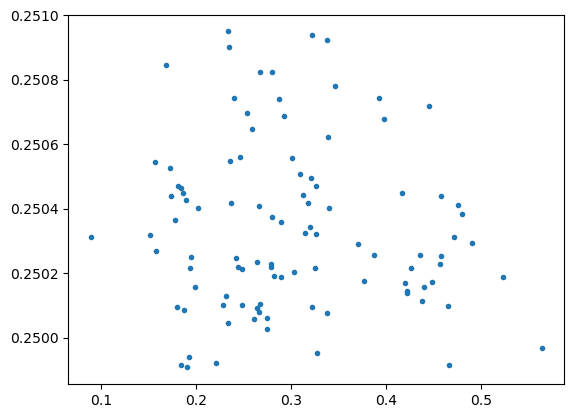

In [58]:
plt.plot(batch_labels, np.concatenate(pred),  '.')